# Enobio Motor Screening
Use this notebook to look through the motor imagery data collected using the NeuroElectrics Enobio (2019.01.16).

In [26]:
from matplotlib import pyplot as plt
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv
import mne

Function to convert .easy files from NIC2 (recording software for Enobio) to Pandas dataframe

## Variables to Set

In [3]:
subjID = 'nile'
filename_eeg = '../data/Enobio/20190109103635_nile_motor_screening_R1.easy'
filename_behavioral = '../data/Enobio/nile_Motor_Screening_R1.csv'

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [4]:
def ConvertEasyToDataFrame(filename):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    import pandas as pd
    
    # Read in the .easy file
    df = pd.read_csv(filename, delimiter='\t', header=None)
    
    # Get metadata from the .info file
    fname = filename[:-5] + '.info'
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Get the channel names
    channel_info = [x for x in content if 'Channel ' in x]
    channel_names = []
    for ch in range(len(channel_info)):
        channel_names.append(channel_info[ch].split(': ')[1])
        
    channel_names.append('X')
    channel_names.append('Y')
    channel_names.append('Z')
    channel_names.append('STI 014')
    channel_names.append('DateTime')
    
    # Get sampling rates
    sampling_rates = [x for x in content if 'sampling rate: ' in x]
    fs_all = []
    for freq in range(len(sampling_rates)):
        fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

    # Store sampling rates
    fs = fs_all[0]
    fs_accel = fs_all[1]
    
    # Assign the column names
    df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [5]:
EEGdata, fs, fs_accel = ConvertEasyToDataFrame(filename_eeg)
EEGdata.head()

,Fz,FC1,Cz,C3,C4,Pz,P3,P4,X,Y,Z,STI 014,DateTime
0,-64218719,-91824399,-8338166,-2030945,-49758630,-2714348,-14760972,-96655237,0,0,0,0,1547058995082
1,-64229019,-91834126,-8313513,-2063131,-49748140,-2760029,-14809848,-96646272,0,0,0,0,1547058995084
2,-64314420,-91799603,-8309317,-2039480,-49770408,-2718305,-14765502,-96629869,0,0,0,0,1547058995086
3,-64416797,-91751157,-8329821,-1985502,-49809080,-2631378,-14674283,-96621715,0,0,0,0,1547058995088
4,-64524849,-91692363,-8367157,-1904297,-49862247,-2502680,-14540435,-96621334,647,9590,-647,0,1547058995090


In [6]:
# Check shape of the data
np.shape(EEGdata)

(324321, 13)

Plot all channel data

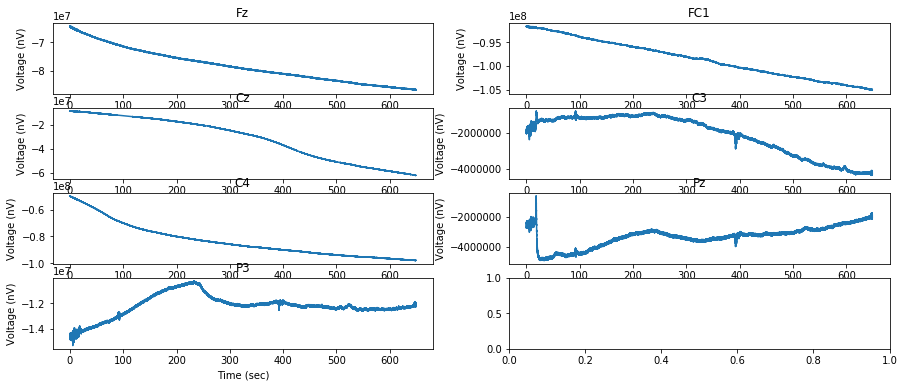

In [11]:
# Create the time array
time = np.linspace(0, np.shape(EEGdata)[0]/fs, np.shape(EEGdata)[0])

fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
for chanOfInt in EEGdata.columns[0:7]:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

Plot event marker data

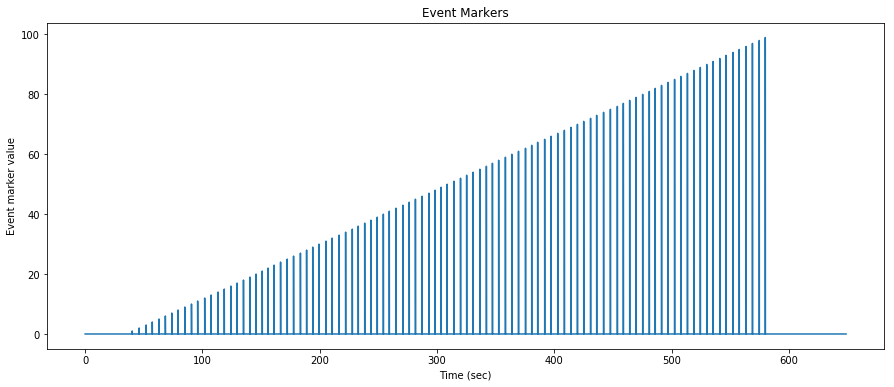

In [12]:
plt.figure(figsize=(15,6))
plt.plot(time, EEGdata['STI 014'])
plt.xlabel('Time (sec)')
plt.ylabel('Event marker value')
plt.title('Event Markers')
plt.show()

## Load the behavioral data

In [13]:
behavioralData = pd.read_csv(filename_behavioral, ',')
behavioralData = behavioralData.transpose()

# Saving header information
behavioralHeader = behavioralData.iloc[0]

behavioralData = behavioralData.iloc[2:]
behavioralData.columns = behavioralHeader
behavioralData.head()

Unnamed: 0,trialStart,stimulus,trialLength,trialType
trial_0,20.627180866897106,right,4,R
trial_1,26.05218400293961,right,4,R
trial_2,31.890687201870605,right,4,R
trial_3,37.855548202292994,left,4,L
trial_4,43.127350472146645,left,4,L


### Sync up event markers / trigger pulses
Note that for the DSI-7, we sound audio beeps that are sent as pulses through the trigger hub and are recorded with the EEG. For the Enobio, we use Lab Streaming Layer (LSL) to send direct pulses with integer values to the recording software.

In [14]:
np.unique(EEGdata['STI 014'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [15]:
# Store where the values in trigger are equal to 8 (the audio trigger input channel number)
index_trigger = np.where(EEGdata['STI 014']!=0)
index_trigger = index_trigger[0]
index_trigger

array([ 20087,  23006,  25988,  28624,  31529,  34195,  36940,  39627,
        42479,  45336,  47966,  50963,  53713,  56628,  59309,  62115,
        64803,  67496,  70235,  72853,  75500,  78016,  80539,  83304,
        86149,  88840,  91768,  94398,  97012,  99682, 102681, 105314,
       108263, 111028, 113880, 116419, 119157, 121823, 124512, 127109,
       129641, 132456, 135420, 138152, 140782, 143620, 146539, 149141,
       151761, 154296, 157181, 160008, 162617, 165359, 168231, 171027,
       173604, 176258, 179136, 181856, 184714, 187704, 190335, 192883,
       195869, 198620, 201434, 204263, 207124, 209830, 212508, 215431,
       218031, 220977, 223882, 226848, 229398, 232098, 234867, 237637,
       240468, 242988, 245684, 248501, 251243, 253895, 256720, 259451,
       262209, 264948, 267679, 270496, 273161, 276151, 278800, 281737,
       284427, 287336, 289905], dtype=int64)

In [16]:
np.shape(index_trigger)

(99,)

In [17]:
# Check number of trials
num_of_trials = behavioralData.shape[0]
num_of_trials

100

In [18]:
if num_of_trials > len(index_trigger):
    num_of_trials = num_of_trials - 1
    num_trials_removed = 1
else:
    num_trials_removed = 0

In [19]:
num_trials_removed

1

Get the trial and rest start and end times

### !!! IMPORTANT !!!
Skipping the first trial in the for loop `for i in range(1` instead of `for i in range(0` because the pulse value sent over for the first trial is `0` which is equal to when there is no pulse being sent... AKA we can't know for sure when the first trial started

In [20]:
trialLength = int(behavioralData['trialLength'][0])

# Get trial timing
t_trial_start = list()
t_trial_end = list()

# Creating lists of all trigger start and end locations
for i in range(0,num_of_trials):
    t_trial_start.append(index_trigger[i])
    t_trial_end.append(index_trigger[i] + int(trialLength*fs))

# Save rest period epochs as well as trials for comparison
t_rest_start = list()
t_rest_end = list()

for i in range(num_of_trials-1):
    t_rest_start.append(t_trial_end[i])
    t_rest_end.append(t_trial_start[i+1])

## Cleaning the EEG data
Artifact removal and filtering

In [21]:
from mne.filter import filter_data

In [22]:
EEGdata_filt = EEGdata.copy()
channels = EEGdata.columns[0:7]

eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=40)
EEGdata_filt[channels] = filtered.T

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


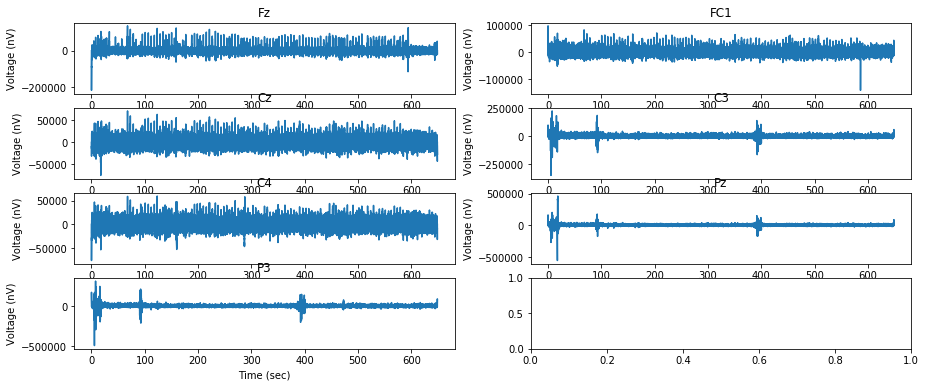

In [24]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:7]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata_filt[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

## Independent Component Analysis (ICA)
First, make a copy of our data and format it such that it can be used with MNE python. Follow tutorial from here https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html

But this page was more useful https://cbrnr.github.io/2018/01/29/removing-eog-ica/

In [27]:
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)

rawData = EEGdata[channels].values
rawData = np.transpose(rawData)

raw = mne.io.array.RawArray(rawData, info)

Creating RawArray with float64 data, n_channels=7, n_times=324321
    Range : 0 ... 324320 =      0.000 ...   648.640 secs
Ready.


In [28]:
raw.filter(l_freq=1, h_freq=40)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawArray  |  None, n_channels x n_times : 7 x 324321 (648.6 sec), ~17.3 MB, data loaded>

<IPython.core.display.Javascript object>


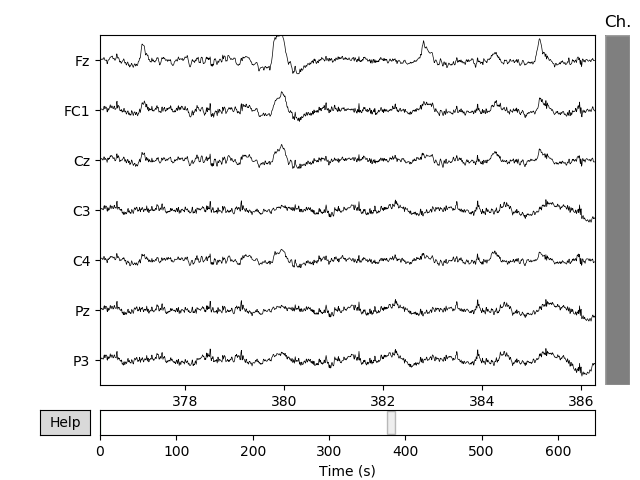

In [29]:
%matplotlib notebook
fig = raw.plot(n_channels=7, scalings='auto')

### Now run ICA

In [30]:
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))

<RawArray  |  None, n_channels x n_times : 7 x 324321 (648.6 sec), ~17.3 MB, data loaded>

In [31]:
n_components = 7
method = 'fastica'
random_state = 23
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)

In [32]:
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, reject=reject)
print(ica)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 7 components
Fitting ICA took 1.3s.
<ICA  |  raw data decomposition, fit (fastica): 324000 samples, 7 components, channels used: "eeg">


<IPython.core.display.Javascript object>


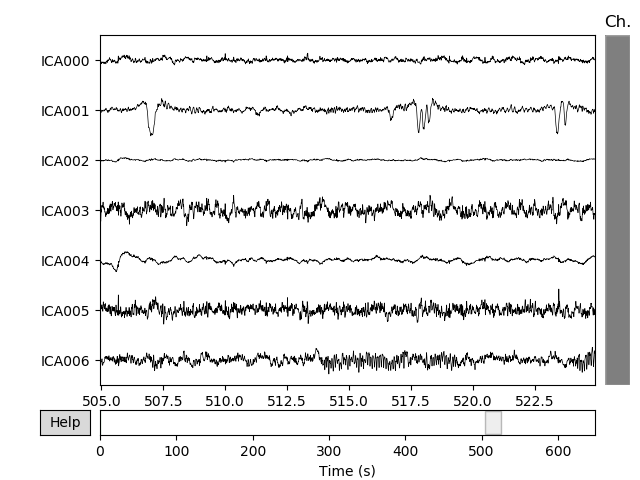

In [33]:
%matplotlib notebook
fig = ica.plot_sources(raw)

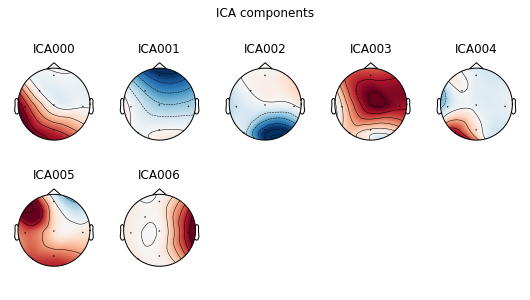

[<Figure size 540x288 with 10 Axes>]

In [34]:
%matplotlib inline
ica.plot_components()

    using multitaper spectrum estimation with 7 DPSS windows


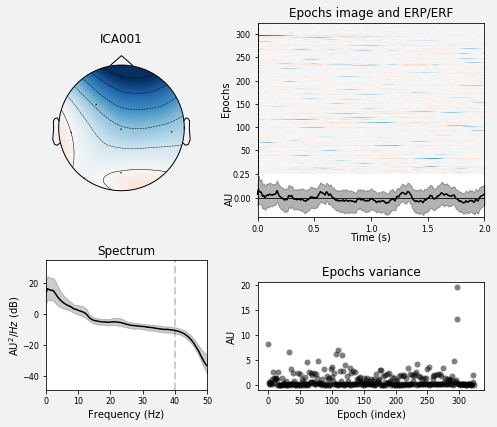

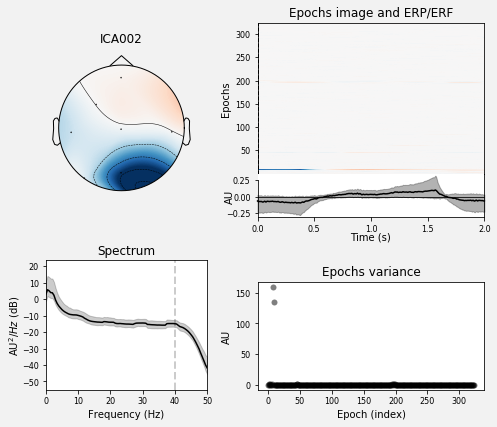

[<Figure size 504x432 with 5 Axes>, <Figure size 504x432 with 5 Axes>]

In [35]:
# Take a closer look at an individual component
%matplotlib inline
ica.plot_properties(raw, picks=[1,2])

### Remove artifacts
Find likely artifacts, remove from signal, and reconstruct signal, then reassign to the dataframe format (to work with in the rest of the code)

In [36]:
ica.exclude = [1] # most likely to be blinks (when you check source you can see clearly)

In [37]:
raw_corrected = raw.copy()
ica.apply(raw_corrected)

Transforming to ICA space (7 components)
Zeroing out 1 ICA components


<RawArray  |  None, n_channels x n_times : 7 x 324321 (648.6 sec), ~17.3 MB, data loaded>

<IPython.core.display.Javascript object>


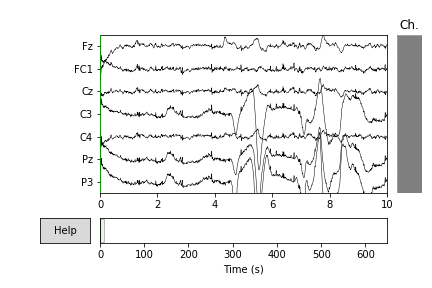

<IPython.core.display.Javascript object>


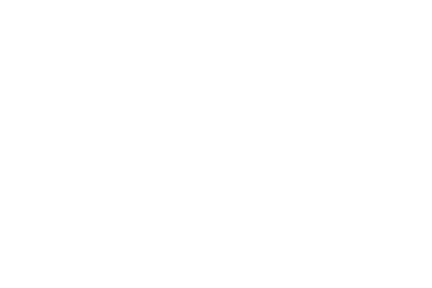

In [38]:
# Plot original
%matplotlib notebook
fig = raw.plot(n_channels = 7, scalings='auto')

<IPython.core.display.Javascript object>


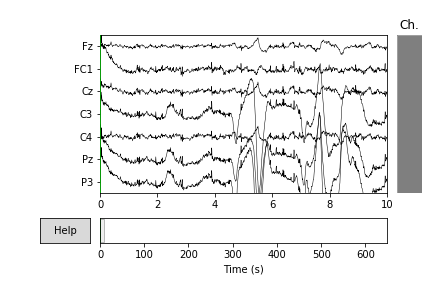

<IPython.core.display.Javascript object>


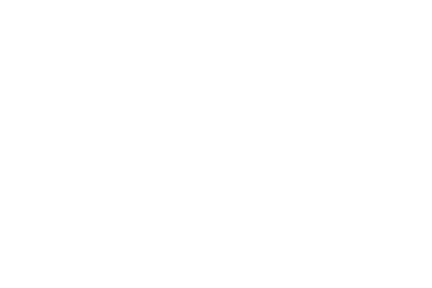

In [39]:
# Plot corrected
fig = raw_corrected.plot(n_channels = 7, scalings='auto')

In [40]:
# Make a copy of the original data just in case
EEGdata_orig = EEGdata.copy()
EEGdata[channels] = raw_corrected.get_data().T
EEGdata_orig.head()

,Fz,FC1,Cz,C3,C4,Pz,P3,P4,X,Y,Z,STI 014,DateTime
0,-64218719,-91824399,-8338166,-2030945,-49758630,-2714348,-14760972,-96655237,0,0,0,0,1547058995082
1,-64229019,-91834126,-8313513,-2063131,-49748140,-2760029,-14809848,-96646272,0,0,0,0,1547058995084
2,-64314420,-91799603,-8309317,-2039480,-49770408,-2718305,-14765502,-96629869,0,0,0,0,1547058995086
3,-64416797,-91751157,-8329821,-1985502,-49809080,-2631378,-14674283,-96621715,0,0,0,0,1547058995088
4,-64524849,-91692363,-8367157,-1904297,-49862247,-2502680,-14540435,-96621334,647,9590,-647,0,1547058995090


In [41]:
EEGdata.head()

,Fz,FC1,Cz,C3,C4,Pz,P3,P4,X,Y,Z,STI 014,DateTime
0,-83.088319,-37.311581,-31.374448,-0.121792,-26.806669,1.314296,-2.800395,-96655237,0,0,0,0,1547058995082
1,4594.690882,69875.015931,20844.591689,35479.027424,164.765811,55627.719725,62049.580490,-96646272,0,0,0,0,1547058995084
2,8534.901391,130433.207593,38796.984571,66082.850751,136.037310,103746.174957,115797.442177,-96629869,0,0,0,0,1547058995086
3,11167.904677,174275.644249,51537.728532,88004.750433,-261.427702,138471.289188,154719.148155,-96621715,0,0,0,0,1547058995088
4,12219.009899,197561.294372,57899.417520,99321.277291,-1051.332892,156780.284071,175440.598105,-96621334,647,9590,-647,0,1547058995090


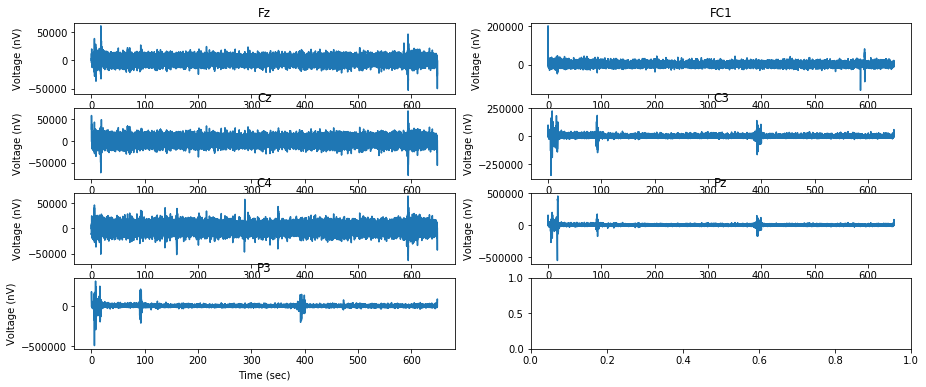

In [42]:
%matplotlib inline
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:7]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

## Epoch and visualize the data
Separate the data by trials (cleaned "raw" data and frequency information) and visually inspect the time-frequency information for the trial conditions. Does power in any particular band look consistently different for math vs non-math trials?

In [317]:
epochs = []
epochs_filt = []

for trial in range(0,len(t_trial_start)):
    epochs.append(EEGdata.loc[t_trial_start[trial]:t_trial_end[trial]][channels])
    epochs_filt.append(EEGdata_filt.loc[t_trial_start[trial]:t_trial_end[trial]][channels])

In [318]:
epochs_norm = []

for trial in range(0,len(t_trial_start)):       
    t_start = t_trial_start[trial]
    t_end = t_trial_end[trial]
    
    # Baseline
    if trial == 0:
        tb_start = t_trial_start[trial] - np.round(1.5*fs)
        tb_end = t_trial_start[trial]
    else:
        tb_start = t_trial_end[trial-1]
        tb_end = t_trial_start[trial]

    baseline = EEGdata.loc[tb_start:tb_end][channels]
    
    # Store epoch
    tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
    epochs_norm.append(tmp)

In [319]:
# This ends up returning a list of dataframes where df[trial number][channels]
epochs[0].head()

,Fz,FC1,Cz,C3,C4,Pz,P3
20087,273.963149,-1936.214206,-720.627251,-10205.213983,2051.552510,-13866.099913,-13731.964133
20088,602.315179,-1740.106631,-277.821273,-10113.389729,2058.145668,-13868.125922,-13787.206371
20089,1141.943853,-1269.550704,473.762635,-10021.259140,2433.718251,-13801.664651,-13820.196677
20090,1777.794086,-615.402472,1376.471315,-9949.467283,3063.937121,-13683.856583,-13828.581756
20091,2369.124220,88.643474,2232.999744,-9929.982849,3781.134593,-13556.188699,-13829.164733


In [320]:
epochs_norm[0].head()

,Fz,FC1,Cz,C3,C4,Pz,P3
20087,0.169509,-0.223971,-0.028460,-1.410978,0.393498,-1.844263,-1.580625
20088,0.240634,-0.197561,0.038364,-1.399699,0.394488,-1.844505,-1.586868
20089,0.357525,-0.134189,0.151787,-1.388383,0.450833,-1.836580,-1.590596
20090,0.495259,-0.046093,0.288015,-1.379565,0.545381,-1.822532,-1.591544
20091,0.623349,0.048723,0.417275,-1.377172,0.652978,-1.807309,-1.591610


In [321]:
# See how many trials we have
len(epochs)

99

A useful link on spectrogram settings https://stackoverflow.com/questions/43353172/producing-spectrogram-from-microphone/43454643

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


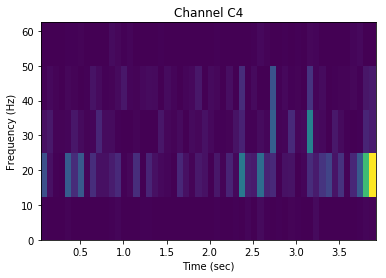

In [322]:
chanOfInt = 'C4'
trialOfInt = 15

ds_factor = 4 # downsampling factor
f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_norm[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)

# nperseg determines size of time bins, number of time bins = fs/nperseg - 1

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Channel ' + chanOfInt)
plt.show()

## Organize by trial type
Create lists containing trial numbers for the different types of trials

| Trial Type | Direction                    |
|------------|------------------------------|
| L          | Imagine Left Hand Movement   |
| R          | Imagine Right Hand Movement  |

In [323]:
# Create lists for each trial type
trialL = list()
trialR = list()
i = 0

for letter in behavioralData['trialType'][1:]:
    if letter == 'L':
        trialL.append(i)
    elif letter == 'R':
        trialR.append(i)
    i += 1

print(trialL)

[2, 3, 4, 5, 8, 10, 13, 17, 18, 19, 20, 23, 25, 26, 27, 32, 35, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 54, 57, 58, 61, 62, 64, 66, 69, 75, 80, 81, 82, 84, 85, 87, 89, 91, 92, 94, 95, 96]


In [324]:
# Create a single list that includes which trial is which
trial_type = list()
i = 0

for letter in behavioralData['trialType'][1:]:
    if letter == 'L':
        trial_type.append(0)
    elif letter == 'R':
        trial_type.append(1)
    i += 1

## Compare the data
Compare the average spectrograms for each type of trial

In [325]:
def PlotAverageSpectrogram(epochs, trials, chanOfInt, fs, ds_factor):
    """
    Input
    epochs: your data epochs (raw)
    trials: list or array of trials you wish to include in the average (e.g., all trials of type A)
    chanOfInt: name of the channel of interest
    fs: sampling rate
    ds_factor: downsampling factor
    """

    Sxx_all = list()

    for trialOfInt in trials:
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
        # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
        # nperseg = number of segments per second, so 10 = 100 ms chunks
        Sxx_all.append(Sxx)

    Sxx_avg = np.mean(Sxx_all,0)
    
    return f, t, Sxx_avg

### Plot

Plot spectrograms for both left hand and right hand motor imagery

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

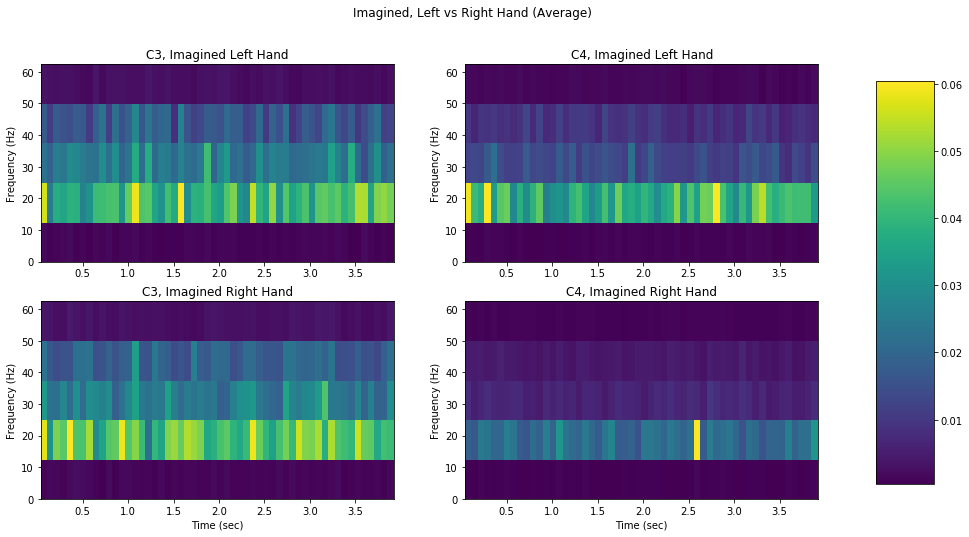

In [326]:
# Get average spectrogram values across trials
channelsOfInt = ['C3','C4','C3','C4']
trials = [trialL, trialL, trialR, trialR]
ds_factor = 4 # downsampling factor

# Set up for plotting
Nr = 2
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Imagined, Left vs Right Hand (Average)')
i = 0

for ax in axes.flat:
    f, t, Sxx_avg = PlotAverageSpectrogram(epochs_norm, trials[i], channelsOfInt[i], fs, ds_factor)
    im = ax.pcolormesh(t, f, Sxx_avg)
    if i >=Nc:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Imagined Right Hand')
    else:
        ax.set_title(channelsOfInt[i] + ', Imagined Left Hand')
    ax.set_ylabel('Frequency (Hz)')
    i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

Check rest trials as well

In [327]:
rest_times = list()
for i in range(0,len(t_rest_start)):
    rest_times.append(t_rest_end[i]-t_rest_start[i])

min_rest = np.min(rest_times)

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

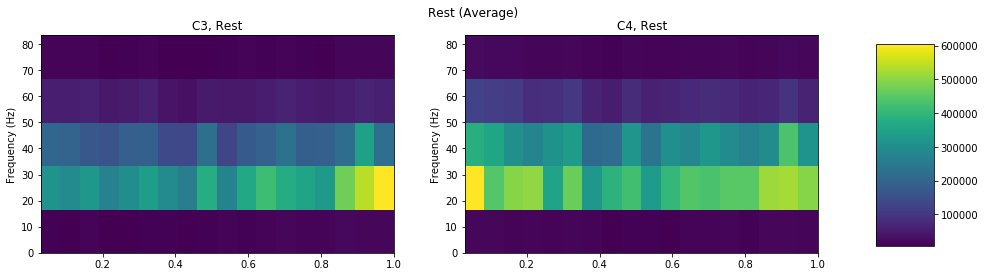

In [328]:
# Get average spectrogram values across trials
channelsOfInt = ['C3','C4']
ds_factor = 3 # downsampling factor

# Set up for plotting
Nr = 1
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,4))
fig.suptitle('Rest (Average)')
i = 0

for ax in axes.flat:
    Sxx_all = list()
    chanOfInt = channelsOfInt[i]

    for rest_num in range(0,len(rest_times)):
        f, t, Sxx = scisig.spectrogram(scisig.decimate(EEGdata[chanOfInt][rest_times[rest_num]:rest_times[rest_num]+min_rest], ds_factor), fs/ds_factor, nperseg=10)
        # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
        # nperseg = number of segments per second, so 10 = 100 ms chunks
        Sxx_all.append(Sxx)

    Sxx_avg = np.mean(Sxx_all,0)
    
    im = ax.pcolormesh(t, f, Sxx_avg)
    if i >=Nc:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Rest')
    else:
        ax.set_title(channelsOfInt[i] + ', Rest')
    ax.set_ylabel('Frequency (Hz)')
    i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

### Save the data

In [329]:
ch_C3 = EEGdata.columns.get_loc('C3')
ch_C4 = EEGdata.columns.get_loc('C4')

In [330]:
[ch_C3, ch_C4]

[3, 4]

In [331]:
# Store spectrogram data for each trial, for each channel
ds_factor = 4 # downsampling factor
channels_to_use = ['C3', 'C4'] # can also specify, like ['C3','C4'], or channels
epochs_Sxx = [[]]*len(channels_to_use)
i = 0

for chanOfInt in channels_to_use:
    tmp = list()
    for trial in range(0,len(trial_type)):
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_norm[trial][chanOfInt].T, ds_factor), fs/ds_factor, nperseg=10)
        tmp.append(Sxx.flatten('C')) # if you want all frequency data
        #tmp.append(Sxx[1]) # if you just want second frequency bin (10-20 Hz if you do ds_factor = 3)
    epochs_Sxx[i] = tmp
    i += 1

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [332]:
# Should be num of channels x num of trials x number of spectrogram data points
# So, 7 x 100 x 330
np.shape(epochs_Sxx)

(2, 99, 330)

## Classify epochs
See if you can reliably classify math vs non-math trials (reflecting differences in DMN activity)

In [333]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

Format the data to feed into a model

In [334]:
epochs_collapsed = []

# Concatenate all epochs such that shape is (num of trials x (flattened channels and spec data))
# So this should be 100 x 2310 (which is 7 channels * 330 spectrogram data points)
num_of_channels = np.shape(epochs_Sxx)[0]
num_of_trials = np.shape(epochs_Sxx)[1]
num_of_specData = np.shape(epochs_Sxx)[2]

epochs_collapsed = np.asarray(epochs_Sxx).reshape(num_of_trials, num_of_channels * num_of_specData)

In [335]:
# Double check we as many examples as we do number of trials
np.shape(epochs_collapsed)

(99, 660)

In [336]:
# Assign your input and labels
X = epochs_collapsed
y = trial_type

# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]

In [337]:
args

array([39,  1, 14, 52, 63, 13, 15, 92, 67, 18, 43, 48, 59, 69, 87, 81, 77,
       36, 97, 57, 54,  3, 20, 71, 49, 25, 68, 11, 79, 89, 91, 12, 62, 40,
       50, 28, 64, 30, 51, 45, 96, 32, 76, 29,  0, 42,  5, 74, 82, 44,  9,
       66, 85, 27, 23, 41, 26, 21, 16, 22, 19, 88, 60, 93, 80, 94, 61,  8,
       35, 33, 24, 73, 72, 78, 55, 86, 95, 53, 37,  4, 98, 70,  6, 75, 46,
        7, 31, 83, 17, 56, 38, 65, 47,  2, 58, 90, 10, 84, 34])

In [338]:
# Separate into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Determine model parameters

In [339]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
hyper_params = {"C":C_range, "gamma":gamma_range}
grid = GridSearchCV(SVC(kernel='poly'), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

In [340]:
#grid.fit(X_train, y_train)

In [341]:
#grid.best_estimator_

### Fit the model

In [342]:
svc = SVC(kernel='poly', C=0.01, degree=3, gamma=0.01, verbose=True)
svc.fit(X_train, y_train)

[LibSVM]

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

### Evaluate

In [343]:
print('Using spectrogram data from all channels')
print('Training Score: ' + str(svc.score(X_train, y_train)))
print('Test Score: ' + str(svc.score(X_test, y_test)))

Using spectrogram data from all channels
Training Score: 0.5189873417721519
Test Score: 0.4


Confusion matrix

Remember L = imagine left, R = imagine right

| .        | Pred L | Pred R |
|----------|--------|--------|
| Actual L | TP     | .      |
| Actual R | .      | TP     |

In [344]:
confusion_matrix(y_test, svc.predict(X_test))

array([[ 0, 12],
       [ 0,  8]], dtype=int64)

### Visualize principal components

In [345]:
from mpl_toolkits.mplot3d import Axes3D

In [346]:
# Run PCA
pca = PCA(n_components=3)
results = pca.fit_transform(X)

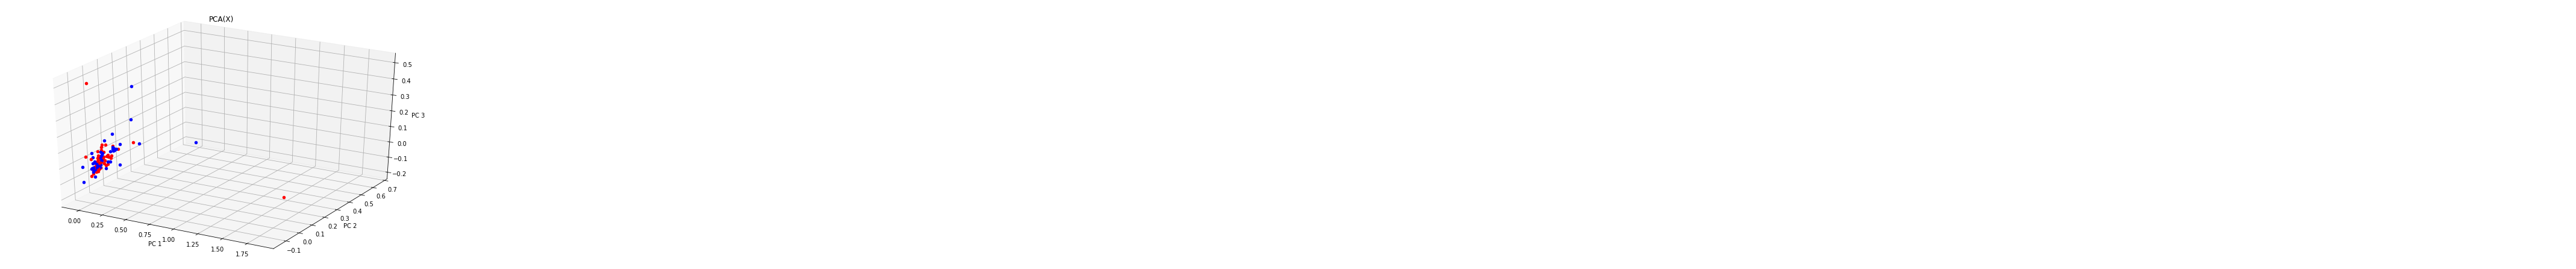

Blue = imagine left, Red = imagine right


In [347]:
# Plot
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
i=0
for num in y:
    # print(str(num))
    if num == 0:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='blue')
    elif num == 1:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='red')
    i = i +1

ax.set_title('PCA(X)')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()
print('Blue = imagine left, Red = imagine right')

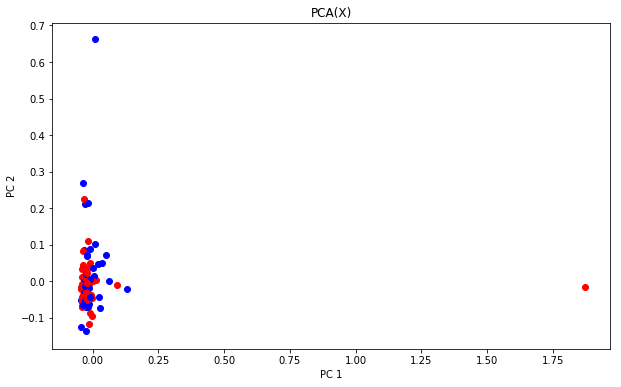

Blue = imagine left, Red = imagine right


In [348]:
# Run PCA
pca = PCA(n_components=2)
results = pca.fit_transform(X)

# Plot
fig = plt.figure(figsize=(10,6))
i=0
for num in y:
    # print(str(num))
    if num == 0:
        plt.scatter(results[i, 0], results[i, 1], c='blue')
    elif num == 1:
        plt.scatter(results[i, 0], results[i, 1], c='red')
    i = i +1

plt.title('PCA(X)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
print('Blue = imagine left, Red = imagine right')

Visualize classification...

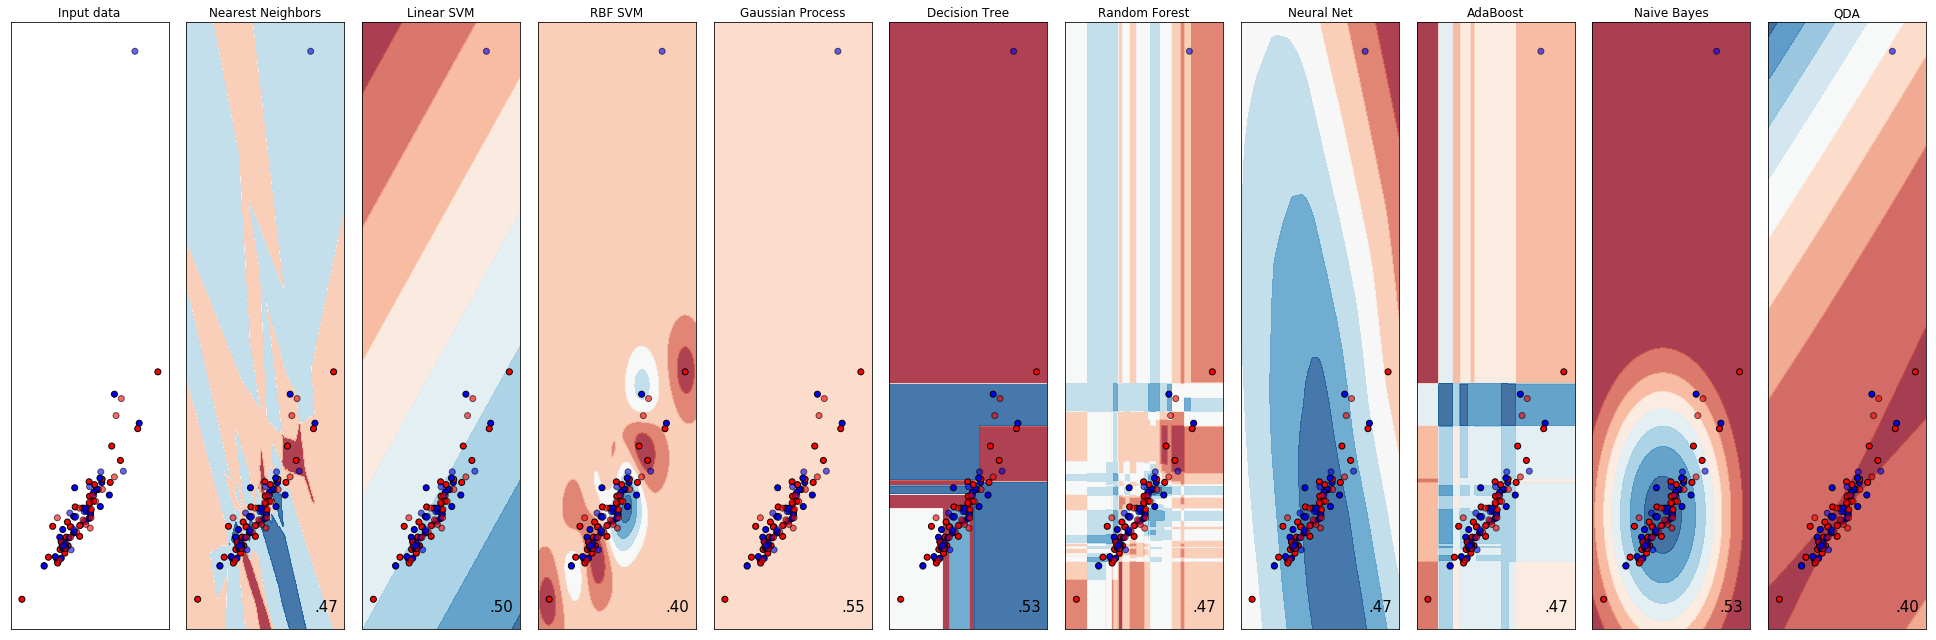

In [349]:
# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part
X = [np.mean(epochs_collapsed,1),np.std(epochs_collapsed,1)]
X = np.asarray(X).T
np.shape(X)
y = trial_type
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

## Let's try other classification
Looking at the results from trying multiple classification methods above, let's use one that looks better than SVM. So here, it looks like random forest might be the best for this current case.

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\tight_layout.py:335: UserWarning: tight_layout not applied: number of columns in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


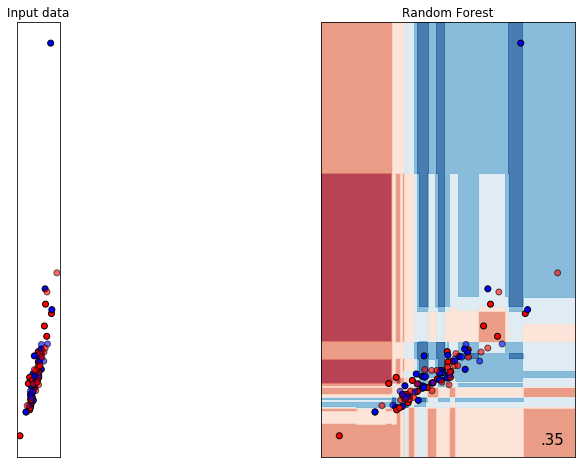

In [350]:
h = .02  # step size in the mesh

figure = plt.figure(figsize=(10, 8))
i = 1

# preprocess dataset, split into training and test part
X = [np.mean(epochs_collapsed,1),np.std(epochs_collapsed,1)]
X = np.asarray(X).T
y = trial_type
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
name = "Random Forest"
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

ax = plt.subplot(1, 1 + 1, i)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
        size=15, horizontalalignment='right')


plt.tight_layout()
plt.show()

Confusion matrix

Remember L = imagine left, R = imagine right

| .        | Pred L | Pred R |
|----------|--------|--------|
| Actual L | TP     | .      |
| Actual R | .      | TP     |

In [351]:
confusion_matrix(y_test, clf.predict(X_test))

array([[ 6, 18],
       [ 8,  8]], dtype=int64)

## Save the model

In [352]:
import pickle
import datetime

In [353]:
model = clf
model_file = subjID + '_MI_classifier_' + datetime.datetime.now().isoformat()[:10] + '.sav'
pickle.dump(model, open(model_file, 'wb'))

In [354]:
# And to load
loaded_model = pickle.load(open(model_file, 'rb'))
print(loaded_model.score(X_test, y_test))

0.35


When you make this all into a function, it should save both the model and the data it was trained/tested on.

**Input**: subjID, EEGdatafile, behavioraldatafile

**Output**: X, y, model

In [355]:
tmp = datetime.datetime.now().isoformat()
tmp

'2019-01-16T14:13:54.035780'

In [356]:
time_to_save = datetime.datetime.now().isoformat()
time_to_save = time_to_save.replace('T','-')
time_to_save = time_to_save.replace(':','-')

In [357]:
filepath_export_data = 'data_for_training_' + time_to_save[:19] + '.npz'
np.savez_compressed(filepath_export_data, X=X, y=y)

In [358]:
npzfile = np.load(filepath_export_data)

In [359]:
npzfile.files

['X', 'y']

In [360]:
np.shape(npzfile['X'])

(99, 2)

## Test a different way to represent the data
Let's try not relying on the spectrogram function

In [361]:
from scipy.fftpack import fft, ifft
from scipy import signal

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


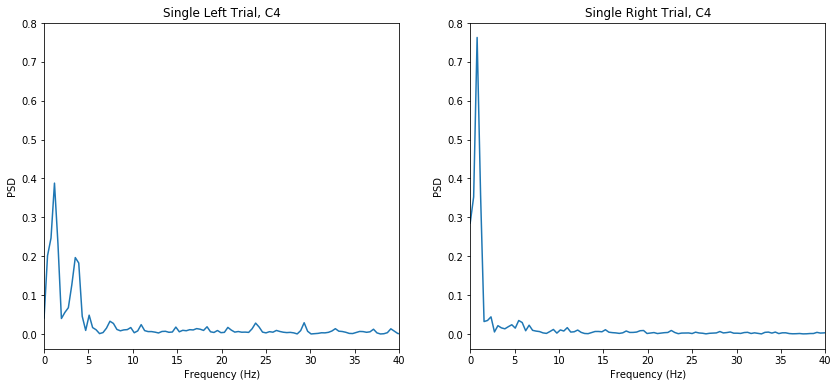

In [362]:
i = 10
chanOfInt = 'C4'
ds_f = 5 # downsample factor
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)


f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trialL[i]][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
ax1.plot(f, Pxx_den)
ax1.set_xlim([0, 40])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('PSD')
ax1.set_title('Single Left Trial, ' + chanOfInt)

f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trialR[i]][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
ax2.plot(f, Pxx_den)
ax2.set_xlim([0, 40])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD')
ax2.set_title('Single Right Trial, ' + chanOfInt)

plt.show()

In [363]:
# Get the summed delta power for each trial
channelsToUse = ['C3','C4']
alpha_power = dict.fromkeys(channelsToUse)
beta_power = dict.fromkeys(channelsToUse)
ds_f = 1 # downsampling factor

for chanOfInt in channelsToUse:
    tmp_alpha = list()
    tmp_beta = list()
    
    for trial in range(0, num_of_trials):
        f, Pxx_den = signal.welch(signal.decimate(epochs[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
        alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
        tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))
        
        beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
        tmp_beta.append(np.sum(Pxx_den[beta_idx]))
        
    alpha_power[chanOfInt] = tmp_alpha
    beta_power[chanOfInt] = tmp_beta

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


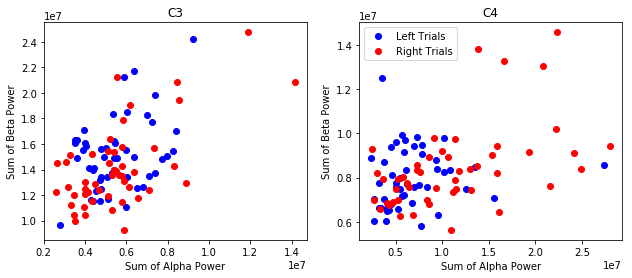

In [364]:
channelsToUse = ['C3', 'C4']
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(130 + cnt)
    tmp_alpha = np.asarray(alpha_power[chanOfInt])
    tmp_beta = np.asarray(beta_power[chanOfInt])
    plt.plot(tmp_alpha[trialL], tmp_beta[trialL], 'bo')
    plt.plot(tmp_alpha[trialR], tmp_beta[trialR], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Sum of Alpha Power')
    plt.ylabel('Sum of Beta Power')
    cnt += 1

plt.legend(['Left Trials','Right Trials'])
plt.show()

The above keeps C3 and C4 independent. What if we were to plot data points such that it's like alpha power for C3 (x-axis) and C4 (y-axis) and a separate plot for beta power for C3 (x-axis) and C4 (y-axis)?

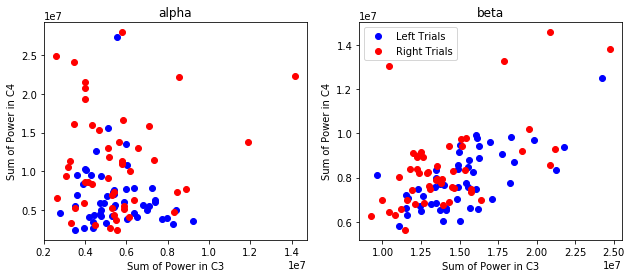

In [365]:
bandsToUse = ['alpha', 'beta']
plt.figure(figsize=(16,4))

i = 0
cnt = 1
for bandOfInt in bandsToUse:
    plt.subplot(130 + cnt)
    if i == 0:
        tmp = alpha_power
    else:
        tmp = beta_power
    tmp_C3 = np.asarray(tmp['C3'])
    tmp_C4 = np.asarray(tmp['C4'])
    plt.plot(tmp_C3[trialL], tmp_C4[trialL], 'bo')
    plt.plot(tmp_C3[trialR], tmp_C4[trialR], 'ro')
    
    plt.title(bandOfInt)
    plt.xlabel('Sum of Power in C3')
    plt.ylabel('Sum of Power in C4')
    cnt += 1
    i += 1

plt.legend(['Left Trials','Right Trials'])
plt.show()

### Test classifying using this
Let's try using the sum of power in C3 and C4 for alpha and beta as our new data to classify

In [366]:
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

In [367]:
np.shape(motor_features)

(99, 4)

Note that this multi model visualization only takes in 2D input, so I cut down just to alpha for here...

In [368]:
# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part
X = motor_features
y = trial_type
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)


# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    print(name + ', score: ' + str(score))


Nearest Neighbors, score: 0.525
Linear SVM, score: 0.65
RBF SVM, score: 0.55
Gaussian Process, score: 0.65
Decision Tree, score: 0.525
Random Forest, score: 0.7
Neural Net, score: 0.625
AdaBoost, score: 0.675
Naive Bayes, score: 0.675
QDA, score: 0.55


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<Figure size 1944x648 with 0 Axes>

Let's just try training an individual model using the full input (4D, not 2D), and also account for class imbalance.

Remember L = imagine left, R = imagine right

| .        | Pred L | Pred R |
|----------|--------|--------|
| Actual L | TP     | .      |
| Actual R | .      | TP     |

In [369]:
# Fit a simple neural network (multilayer perceptron)
X = motor_features
y = trial_type

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Determine model parameters
activations = ['relu','tanh']
alphas = np.logspace(-6, 3, 10)
solvers = ['lbfgs','sgd']
hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
grid.fit(X_train, y_train)

# Fit the model
clf = grid.best_estimator_
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print(grid.best_estimator_)
print('-----------')
print('score: ' + str(score))
print(confusion_matrix(y_test, clf.predict(X_test)))
print('-----------')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: Convergen

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: Convergen

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
-----------
score: 0.7
[[12  4]
 [ 5  9]]
-----------


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.5s finished
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
